This notebook estimate the space-time correlation in a network of meV axion detectors due to wave interference. Following [Lam Hui's review on wave dark matter](https://arxiv.org/abs/2101.11735).

Apr 18, 2025

In [1]:
# Plotting style
import matplotlib.pyplot as plt
import matplotlib as mpl
# Apply the style
plt.style.use('../xenonnt.mplstyle')

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = [4, 3]
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = 9
mpl.rcParams["mathtext.fontset"] = "dejavuserif"

Eqn 50. says "With a network of detectors, one can measure the correlation function
in space-time":
$$
\left\langle\phi\left(t_1, \vec{x}_1\right)^2 \phi\left(t_2, \vec{x}_2\right)^2\right\rangle-\left\langle\phi^2\right\rangle^2=\frac{\bar{\rho}^2}{m^4}\left(1+\frac{k_0^4\left(t_1-t_2\right)^2}{16 m^2}\right)^{-3 / 2} \exp \left(-\frac{4 k_0^2 m^2\left|\vec{x}_1-\vec{x}_2\right|^2}{16 m^2+k_0^4\left(t_1-t_2\right)^2}\right)
$$

Note that 

$$
\lambda_{\mathrm{dB}} \equiv \frac{2 \pi}{m v}=0.48 \mathrm{kpc}\left(\frac{10^{-22} \mathrm{eV}}{m}\right)\left(\frac{250 \mathrm{~km} / \mathrm{s}}{v}\right)=1.49 \mathrm{~km}\left(\frac{10^{-6} \mathrm{eV}}{m}\right)\left(\frac{250 \mathrm{~km} / \mathrm{s}}{v}\right)
$$

In [69]:
import numpy as np

def compute_k0(m_ev, v_kmS):
    """
    Compute the wave number k0 for the scalar field phi.

    Returns:
    - k0: wave number [m-1]
    """
    return 1/(1.49) * (m_ev/1e-3) * (v_kmS/250)

def compute_time_like_term(m_ev, v_kmS, dt_s):
    """
    Compute the time-like term for the space-time correlation function.
    """
    m_to_cm = 1e2
    # https://sherwingroup.itst.ucsb.edu/internal/unit-conversion/
    eVInv_to_cm = 0.000124
    c_m_sInv = 2.99792458e8

    k0_mInv = compute_k0(m_ev, v_kmS)
    m_mInv = m_ev / (eVInv_to_cm * 1/m_to_cm)
    return (1 + (k0_mInv**4 / (16 * m_mInv**2) * dt_s**2) * c_m_sInv**2)**(-1.5)

def compute_space_like_term(m_ev, v_kmS, dx_m, dt_s):
    """\exp \left(-\frac{4 k_0^2 m^2\left|\vec{x}_1-\vec{x}_2\right|^2}{16 m^2+k_0^4\left(t_1-t_2\right)^2}\right)
    """
    # https://sherwingroup.itst.ucsb.edu/internal/unit-conversion/
    c_m_sInv = 2.99792458e8
    mInv_to_eV = 0.00000124

    # https://sherwingroup.itst.ucsb.edu/internal/unit-conversion/
    k0_mInv = compute_k0(m_ev, v_kmS)
    numerator_eV2 = 4 * k0_mInv**2 * m_ev**2 * dx_m**2
    denominator_eV2 = 16 * m_ev**2 + (k0_mInv**2 * dt_s**2 * c_m_sInv**2) * (k0_mInv**2 * mInv_to_eV**2)
    
    return np.exp(-numerator_eV2 / denominator_eV2)

def space_time_corr(dt_s, dx_m, avgRho_gev_cm3Inv=0.3, m_ev=1e-3, v_kmS=250):
    """
    Compute the space-time correlation function for scalar field phi.

    Parameters:
    - dt_s: time difference t1 - t2 [s]
    - dx_m: spatial separation |x1 - x2| [m]
    - avgRho_gev_cm3Inv: average DM density [GeV/cm^3]
    - m_ev: particle mass [eV]
    - v_kmS: velocity ispersion of dark matter around earth [km/s]

    Returns:
    - correlation value [eV^4]
    """
    # Physical constants
    GeV_to_eV = 1e9
    m_to_cm = 1e2
    # https://sherwingroup.itst.ucsb.edu/internal/unit-conversion/
    cm_to_eVInv = 1/(0.000124) 
    
    # \frac{\bar{\rho}^2}{m^4}
    prefactor_eV4 = (avgRho_gev_cm3Inv * GeV_to_eV / cm_to_eVInv**3)**2

    time_like_term = compute_time_like_term(m_ev=m_ev, v_kmS=v_kmS, dt_s=dt_s)
    space_like_term = compute_space_like_term(m_ev=m_ev, v_kmS=v_kmS, dx_m=dx_m, dt_s=dt_s)

    return prefactor_eV4 * space_like_term * time_like_term


def rel_space_time_corr(dt_s, dx_m, m_ev=1e-3, v_kmS=250):
    """
    Compute the space-time correlation function for scalar field phi relative to average DM density.
    
    Returns:
    - relative correlation value [1]
    """
    time_like_term = compute_time_like_term(m_ev=m_ev, v_kmS=v_kmS, dt_s=dt_s)
    space_like_term = compute_space_like_term(m_ev=m_ev, v_kmS=v_kmS, dx_m=dx_m, dt_s=dt_s)

    return space_like_term * time_like_term

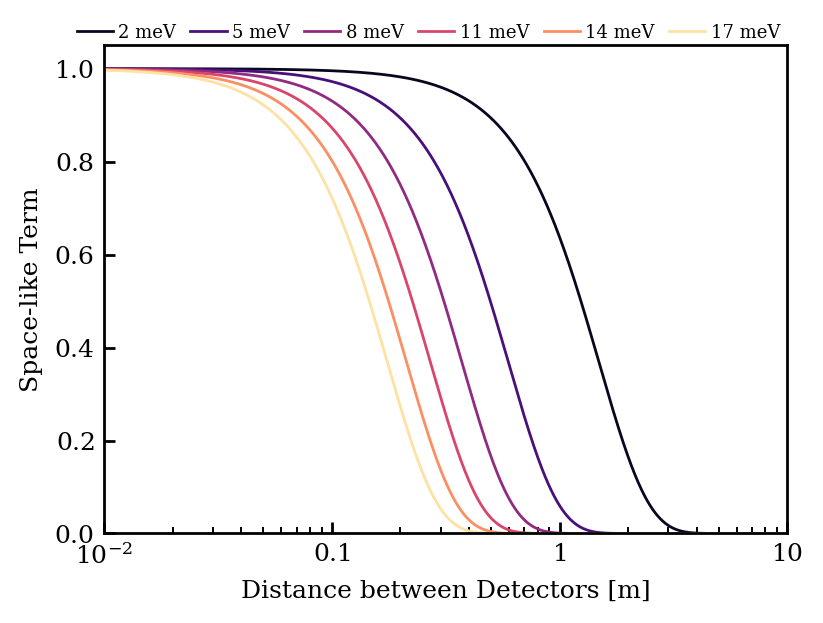

In [62]:
dx_m = np.logspace(-2, 2, 10_000)

m_eVs = [2e-3, 5e-3, 8e-3, 11e-3, 14e-3, 17e-3]

# Set up the magma colormap scaled to your mass range
cmap = plt.cm.magma
norm = plt.Normalize(vmin=1e-3, vmax=18e-3)
for m_ev in m_eVs:
    color = cmap(norm(m_ev))

    x_dB_m = 1.49 * 1e-3 / m_ev
    space_like_term = compute_space_like_term(m_ev=m_ev, v_kmS=250, dx_m=dx_m, dt_s=0)
    plt.plot(dx_m, space_like_term, color=color, label=f"{int(m_ev/1e-3)} meV")

plt.xscale("log")
plt.xlabel("Distance between Detectors [m]")
plt.ylabel("Space-like Term")
plt.legend(ncol=6, fontsize=6.5, loc="upper right", bbox_to_anchor=(1.0, 1.06))
plt.ylim(0)
plt.xlim(1e-2, 10)
plt.show()

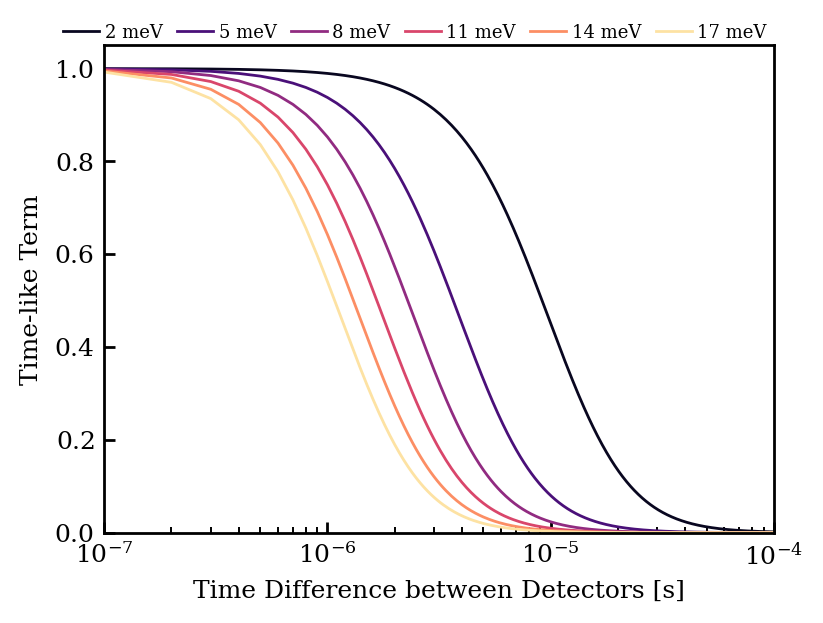

In [58]:
import matplotlib.pyplot as plt
import numpy as np

dt_s = np.linspace(0, 1e-3, 10_000)

m_eVs = [2e-3, 5e-3, 8e-3, 11e-3, 14e-3, 17e-3]

# Set up the magma colormap scaled to your mass range
cmap = plt.cm.magma
norm = plt.Normalize(vmin=1e-3, vmax=18e-3)

for m_ev in m_eVs:
    t_dB_s = 5.9e-6 / m_ev * 1e-3
    time_like_term = compute_time_like_term(m_ev=m_ev, v_kmS=250, dt_s=dt_s)
    
    # Get color from the normalized colormap
    color = cmap(norm(m_ev))
    
    plt.plot(dt_s, time_like_term, color=color, label=f"{int(m_ev/1e-3)} meV")
    #plt.axvline(t_dB_s, ls=":")

plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Time Difference between Detectors [s]")
plt.ylabel("Time-like Term")
plt.ylim(0)
plt.xlim(1e-7, 1e-4)
plt.legend(ncol=6, fontsize=6.5, loc="upper right", bbox_to_anchor=(1.0, 1.06))

# Optional: Add a colorbar to show the mass scale
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=plt.gca())
#cbar.set_label('Mass [eV]', rotation=270, labelpad=15)

plt.show()

## Time correlation between two detectors distant by 20 cm

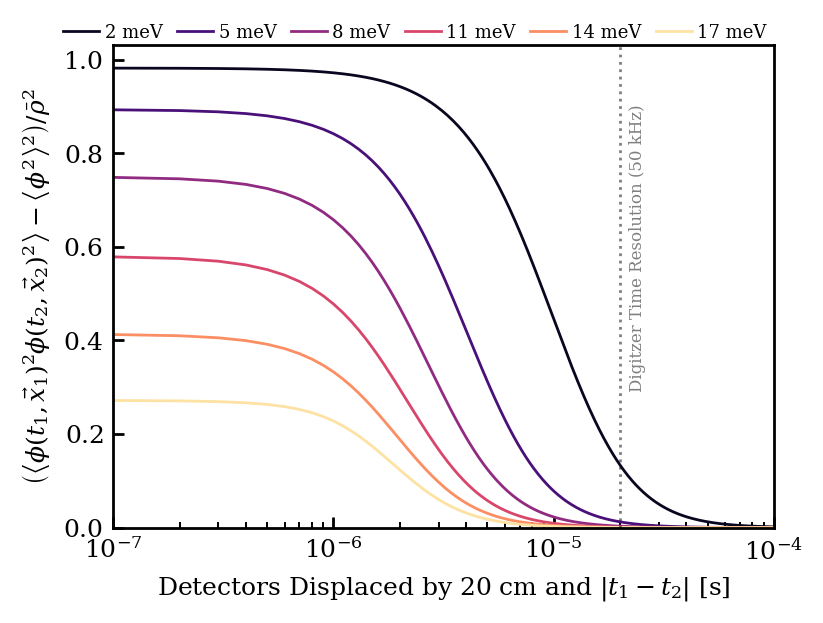

In [79]:
T_RESOLUTION_S = 20e-6

dt_s = np.linspace(0, 1e-3, 10_000)

m_eVs = [2e-3, 5e-3, 8e-3, 11e-3, 14e-3, 17e-3]

# Set up the magma colormap scaled to your mass range
cmap = plt.cm.magma
norm = plt.Normalize(vmin=1e-3, vmax=18e-3)

for m_ev in m_eVs:
    t_dB_s = 5.9e-6 / m_ev * 1e-3
    rel_corr = rel_space_time_corr(dt_s, dx_m=0.2, m_ev=m_ev, v_kmS=250)
    
    # Get color from the normalized colormap
    color = cmap(norm(m_ev))
    
    plt.plot(dt_s, rel_corr, color=color, label=f"{int(m_ev/1e-3)} meV")
    #plt.axvline(t_dB_s, ls=":")

plt.xscale("log")
#plt.yscale("log")
plt.xlabel(r"Detectors Displaced by 20 cm and $|t_1 - t_2|$ [s]")
plt.ylabel(r"$\left(\left\langle\phi\left(t_1, \vec{x}_1\right)^2 \phi\left(t_2, \vec{x}_2\right)^2\right\rangle-\left\langle\phi^2\right\rangle^2\right)/\bar{\rho}^2$")
plt.ylim(0)
plt.xlim(1e-7, 1e-4)
plt.legend(ncol=6, fontsize=6.5, loc="upper right", bbox_to_anchor=(1.0, 1.06))

# Optional: Add a colorbar to show the mass scale
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=plt.gca())
#cbar.set_label('Mass [eV]', rotation=270, labelpad=15)

plt.axvline(T_RESOLUTION_S, ls=":", color="black", alpha=0.5)
plt.text(T_RESOLUTION_S*1.1, 0.3, "Digitzer Time Resolution (50 kHz)", rotation=90, fontsize=6, alpha=0.5)

plt.show()

## Space correlation between two detectors distant by 20 microseconds

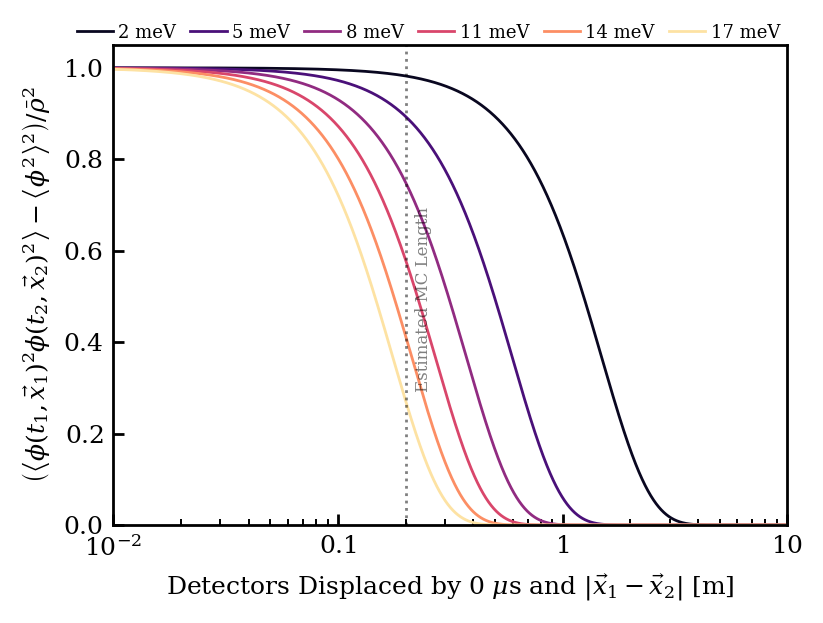

In [89]:
L_QUALIPHIDE = 0.20

dx_m = np.logspace(-2, 2, 10_000)

m_eVs = [2e-3, 5e-3, 8e-3, 11e-3, 14e-3, 17e-3]

# Set up the magma colormap scaled to your mass range
cmap = plt.cm.magma
norm = plt.Normalize(vmin=1e-3, vmax=18e-3)

for m_ev in m_eVs:
    t_dB_s = 5.9e-6 / m_ev * 1e-3
    rel_corr = rel_space_time_corr(dt_s=0, dx_m=dx_m, m_ev=m_ev, v_kmS=250)
    
    # Get color from the normalized colormap
    color = cmap(norm(m_ev))
    
    plt.plot(dx_m, rel_corr, color=color, label=f"{int(m_ev/1e-3)} meV")
    #plt.axvline(t_dB_s, ls=":")

plt.xscale("log")
#plt.yscale("log")
plt.xlabel(r"Detectors Displaced by 0 $\mu$s and $|\vec{x}_1-\vec{x}_2|$ [m]")
plt.ylabel(r"$\left(\left\langle\phi\left(t_1, \vec{x}_1\right)^2 \phi\left(t_2, \vec{x}_2\right)^2\right\rangle-\left\langle\phi^2\right\rangle^2\right)/\bar{\rho}^2$")
plt.ylim(0)
plt.xlim(1e-2, 10)
plt.legend(ncol=6, fontsize=6.5, loc="upper right", bbox_to_anchor=(1.0, 1.06))

# Optional: Add a colorbar to show the mass scale
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=plt.gca())
#cbar.set_label('Mass [eV]', rotation=270, labelpad=15)

plt.axvline(L_QUALIPHIDE, ls=":", color="black", alpha=0.5)
plt.text(L_QUALIPHIDE * 1.1, 0.3, "Estimated MC Length", rotation=90, fontsize=6, alpha=0.5)

plt.show()

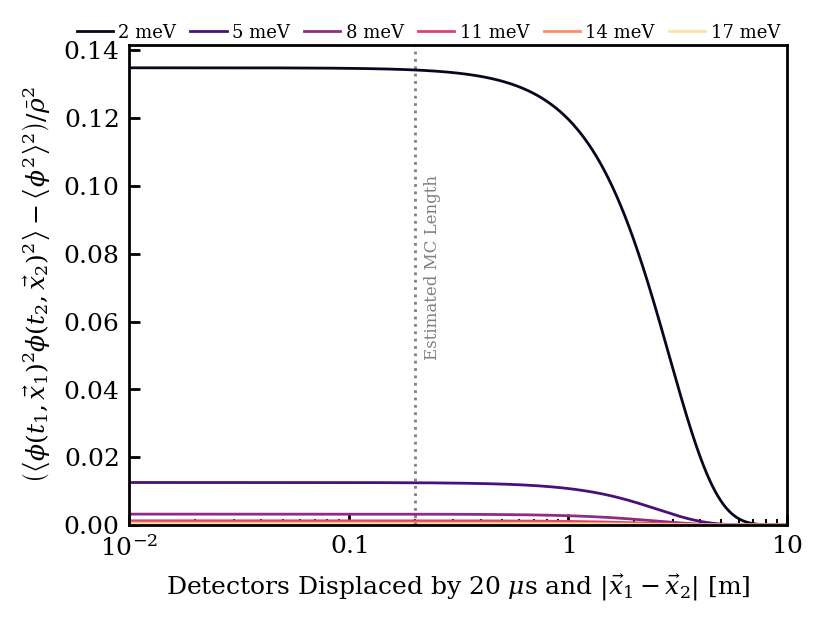

In [92]:
dx_m = np.logspace(-2, 2, 10_000)

m_eVs = [2e-3, 5e-3, 8e-3, 11e-3, 14e-3, 17e-3]

# Set up the magma colormap scaled to your mass range
cmap = plt.cm.magma
norm = plt.Normalize(vmin=1e-3, vmax=18e-3)

for m_ev in m_eVs:
    t_dB_s = 5.9e-6 / m_ev * 1e-3
    rel_corr = rel_space_time_corr(dt_s=T_RESOLUTION_S, dx_m=dx_m, m_ev=m_ev, v_kmS=250)
    
    # Get color from the normalized colormap
    color = cmap(norm(m_ev))
    
    plt.plot(dx_m, rel_corr, color=color, label=f"{int(m_ev/1e-3)} meV")
    #plt.axvline(t_dB_s, ls=":")

plt.xscale("log")
#plt.yscale("log")
plt.xlabel(r"Detectors Displaced by 20 $\mu$s and $|\vec{x}_1-\vec{x}_2|$ [m]")
plt.ylabel(r"$\left(\left\langle\phi\left(t_1, \vec{x}_1\right)^2 \phi\left(t_2, \vec{x}_2\right)^2\right\rangle-\left\langle\phi^2\right\rangle^2\right)/\bar{\rho}^2$")
plt.ylim(0)
plt.xlim(1e-2, 10)
plt.legend(ncol=6, fontsize=6.5, loc="upper right", bbox_to_anchor=(1.0, 1.06))

# Optional: Add a colorbar to show the mass scale
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=plt.gca())
#cbar.set_label('Mass [eV]', rotation=270, labelpad=15)

plt.axvline(L_QUALIPHIDE, ls=":", color="black", alpha=0.5)
plt.text(L_QUALIPHIDE * 1.1, 0.05, "Estimated MC Length", rotation=90, fontsize=6, alpha=0.5)

plt.show()